# Project IRIS
> Incorporated Research Institutions for Seismology

### Libraries Used

- __pandas__       : data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series
- __numpy__        : large, multi-dimensional arrays and matrices, also huge collection of high-level mathematical functions to operate on these data structures
- __matplotlib__   : plotting library
- __datetime__     : manipulates date & time
- __scikit-learn__ : open-source machine learning library
- __tqdm__         : fast, Extensible Progress Bar for Python and CLI
- __plotly__       : open Source Graphing Library for Python
- __dash__         : framework for building web applications in Python


### VS Code Extensions Used

- __Rainbow CSV__ : offers feature packed CSV visualizer with it's custom CSV query language inside VS code environment


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.colors
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output

pd.options.mode.chained_assignment = None  # default='warn'

#### 1. Data cleaning & file conversion

In [2]:
# Converts text to CSV
def txt_to_csv(fileName, sortBy = None):
    separator = '|'
    dataFrame = pd.read_csv('data/' + fileName + '.txt', delimiter= separator)
    dataFrame.columns = dataFrame.columns.str.strip()  # strips whitespace from columns
    dataFrame = dataFrame.map(lambda x: x.strip() if isinstance(x, str) else x) # strips whitespace from values
    
    if (sortBy):
        dataFrame.sort_values([sortBy], axis=0, ascending=[True], inplace=True)
    dataFrame.to_csv('data/' + fileName + '.csv', index = None)


txtDataFiles = ['iris-event-list', 'iris-station-list']
for file in txtDataFiles:
    txt_to_csv(fileName= file, sortBy= 'station')


### 2. Calculate optimal number of cluster using Silhouette method

Loading and preprocessing data...
Performing silhouette method...


Calculating silhouette scores: 100%|██████████| 9/9 [06:44<00:00, 44.95s/it]

Plotting silhouette scores...


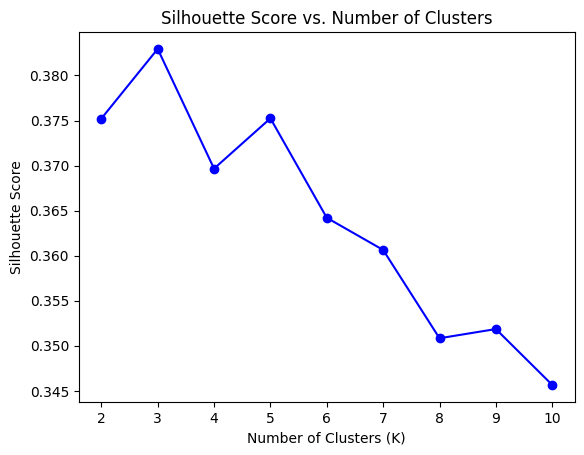

The optimal number of clusters (K) is: 3


In [3]:
def load_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df):
    # Convert 'peak time' to datetime if it's not already
    df['peak time'] = pd.to_datetime(df['peak time'])
    
    # Extract relevant features
    features = df[['peak time', 'peak(dB)']].copy()
    
    # Convert 'peak time' to a numeric value (seconds since epoch)
    features['peak time'] = features['peak time'].astype(np.int64) / 10**9
    
    # Normalize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features

def silhouette_method(data, max_k=10, sample_size=60000):
    silhouette_scores = []
    k_values = range(2, max_k + 1)  # Start from 2 as silhouette score is not defined for k=1
    
    # If the dataset is too large, use a sample
    if len(data) > sample_size:
        data = data[np.random.choice(data.shape[0], sample_size, replace=False)]
    
    for k in tqdm(k_values, desc="Calculating silhouette scores"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    return k_values, silhouette_scores

def plot_silhouette_scores(k_values, silhouette_scores):
    plt.plot(k_values, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.show()

def find_optimal_k(k_values, silhouette_scores):
    return k_values[np.argmax(silhouette_scores)]

def calculate_optimal_k(file_path):
    print("Loading and preprocessing data...")
    df = load_data(file_path)
    scaled_features = preprocess_data(df)
    
    print("Performing silhouette method...")
    k_values, silhouette_scores = silhouette_method(scaled_features)
    
    print("Plotting silhouette scores...")
    plot_silhouette_scores(k_values, silhouette_scores)
    
    optimal_k = find_optimal_k(k_values, silhouette_scores)
    print(f"The optimal number of clusters (K) is: {optimal_k}")
    return optimal_k


optimal_k = calculate_optimal_k("data/iris-event-list.csv") 

### 3. Generate scatter plots & determine centroids

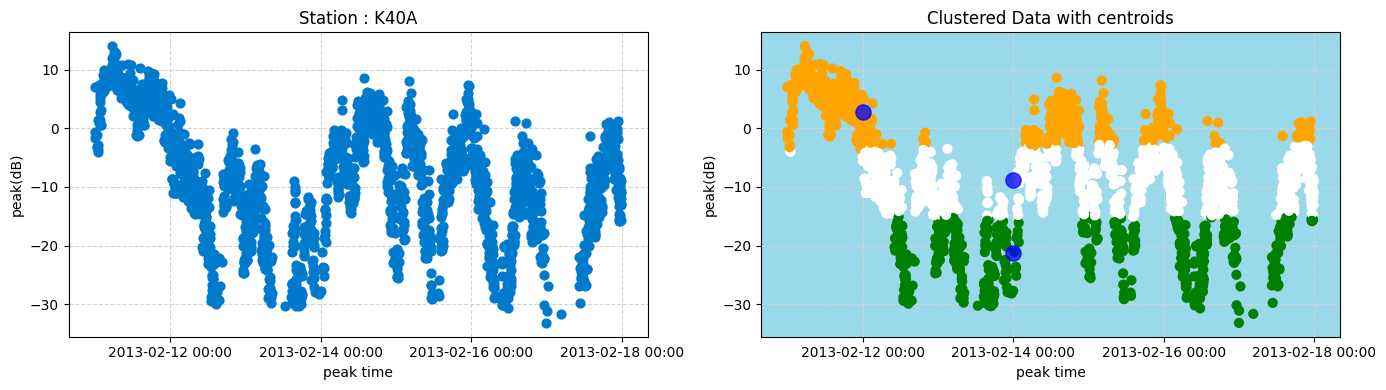

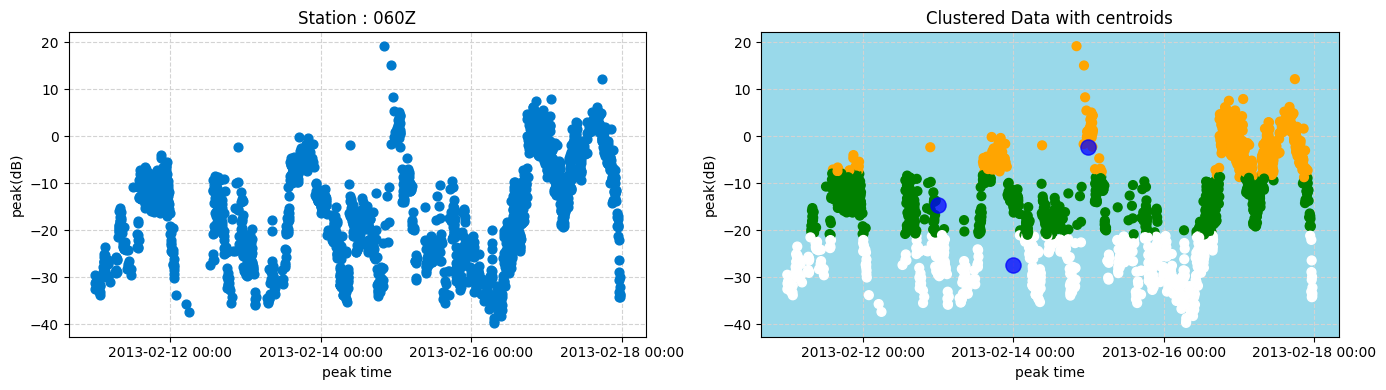

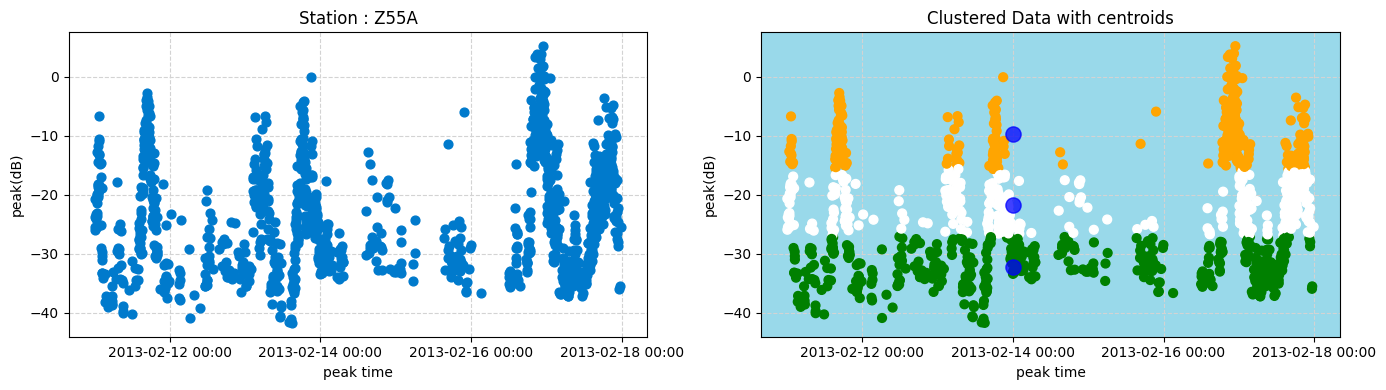

In [25]:
# Generates Scatter Plots
def generateScatterPlots(no_of_cluster, csvData, stations, feature1, feature2):
    
    csvRecords = csvData
    for station in stations:
        fig, axs = plt.subplots(1, 2, figsize=(14, 4), layout="tight")
        plot1 = axs[0]
        plot2 = axs[1]

        # filtering data as per research station 
        data = csvRecords[csvRecords[idColumn] == station]
       
        # convert datetime string into datetime obj
        data[feature1] = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data[feature1]]
        dateOrdinal = data[feature1].map(pd.Timestamp.toordinal)

        # feature values
        f1Values = data[feature1]
        f2Vlaues = data[feature2]
        
        # scatter plot 1
        plot1.set_title('Station : ' + station)
        plot1.scatter(x= f1Values, y= f2Vlaues, c= '#007acc', s= 40)

        # generating clusters
        fillData = np.column_stack((dateOrdinal, f2Vlaues))
        kmeans = KMeans(n_clusters= no_of_cluster, random_state= 2024)
        kmeans.fit(fillData)
        y_kmeans = kmeans.predict(fillData)

        # scatter plot 2
        # plotting the Clusters
        plot2.set_title('Clustered Data with centroids')
        cmapIN = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","orange","white"])
        plot2.set_facecolor("#99D9EA")
        plot2.scatter(f1Values, f2Vlaues, c=y_kmeans, s=40, cmap= cmapIN)

        # plotting the centroids
        centroids = kmeans.cluster_centers_
        centroids_dates = [pd.Timestamp.fromordinal(int(c[0])) for c in centroids]
        plot2.scatter(centroids_dates, centroids[:, 1], c='b', s=120, alpha=0.75)
        
        # setting interval for x axis
        plot1.yaxis.set_major_locator(MultipleLocator(10))
        plot2.yaxis.set_major_locator(MultipleLocator(10))

        # setting interval for y axis
        plot1.xaxis.set_major_locator(mdates.HourLocator(byhour= 00))
        plot1.xaxis.set_major_locator(mdates.DayLocator(interval= 2))
        plot1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plot2.xaxis.set_major_locator(mdates.HourLocator(byhour= 00))
        plot2.xaxis.set_major_locator(mdates.DayLocator(interval= 2))
        plot2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

        # adding dashed grid 
        plot1.set_axisbelow(True)
        plot1.grid(color='lightgray', linestyle='dashed')
        plot2.set_axisbelow(True)
        plot2.grid(color='lightgray', linestyle='dashed')

        # setting x & y labels
        plot1.set_xlabel(feature1)
        plot1.set_ylabel(feature2)
        plot2.set_xlabel(feature1)
        plot2.set_ylabel(feature2)

        plt.show()

records = pd.read_csv('data/iris-event-list.csv')
stations = ['K40A', '060Z', 'Z55A']
f1Column = 'peak time'
f2Column = 'peak(dB)'
idColumn = 'station'
generateScatterPlots(no_of_cluster = optimal_k, csvData= records, stations= stations, feature1= f1Column, feature2= f2Column)

### 4. Generate clusters for each station and analyse meaningful data

In [26]:
def calculate_statistics(cluster_data): 

    return {
        'max_peak_db'        : cluster_data['peak(dB)'].max(),
        'mean_peak_db'       : cluster_data['peak(dB)'].mean(),
        'min_peak_db'        : cluster_data['peak(dB)'].min(),
        'max_background_db'  : cluster_data['background(dB)'].max(),
        'mean_background_db' : cluster_data['background(dB)'].mean(),
        'min_background_db'  : cluster_data['background(dB)'].min(),
        'max_snr_db'         : cluster_data['snr'].max(),
        'mean_snr_db'        : cluster_data['snr'].mean(),
        'min_snr_db'         : cluster_data['snr'].min(),
        'max_duration_sec'   : cluster_data['duration'].max(),
        'mean_duration_sec'  : cluster_data['duration'].mean(),
        'min_duration_sec'   : cluster_data['duration'].min(),
        'start_time'         : cluster_data['start time'].mean(),
        'end_time'           : cluster_data['end time'].mean()
    }


def preprocess_data(df):
    time_columns = ['start time', 'peak time', 'end time']
    for col in time_columns:
        df[col] = pd.to_datetime(df[col])
    df['duration'] = (df['end time'] - df['start time']).dt.total_seconds()
    df['snr'] = df['peak(dB)'] - df['background(dB)'] # Example of a derived measure
    return df


# Function to perform clustering and calculate average duration
def cluster_and_analyze(data, n_clusters):

    data = preprocess_data(data)
    results = []

    for station in data['station'].unique():
        station_data = data[data['station'] == station]
        dynamic_k_cluster = len(station_data) if len(station_data) < n_clusters else n_clusters

        # Extract features for clustering
        featureData = station_data[['peak time', 'peak(dB)']].copy()
        featureData['peak time'] = featureData['peak time'].astype(np.int64) // 10**9  # Convert to Unix timestamp

        # Standardize features
        scaler = StandardScaler()
        featureData_scaled = scaler.fit_transform(featureData)

        # Perform k-means clustering
        kmeans = KMeans(n_clusters= dynamic_k_cluster, random_state= 42)
        station_data['cluster'] = kmeans.fit_predict(featureData_scaled)

        for cluster in range(dynamic_k_cluster):
            
            cluster_data = station_data[station_data['cluster'] == cluster]
            stats = {
                'station': station,
                'cluster': cluster
            } | calculate_statistics(cluster_data)
            results.append(stats)
        
    return pd.DataFrame(results)

cluster_and_analyze(records, optimal_k).to_csv('result/result.csv')

### 5. Visualise station clusters with interactive graph

In [27]:
def visualise_station_clusters():
    # Read the CSV file
    station_cluster_data = pd.read_csv('result/result.csv')
    station_location_data = pd.read_csv('data/iris-station-list.csv')
    df = station_cluster_data.merge(station_location_data, how= 'left')

    # Convert start_time and end_time to datetime
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

    # Sort the dataframe by start_time
    df = df.sort_values(by=["start_time"], ascending=True)
    df.to_csv('result/sorted.csv')

    # Get the min and max values of mean_snr_db for consistent color scale
    cmin = df['mean_snr_db'].min()
    cmax = df['mean_snr_db'].max()

    # Create the Dash app
    app = Dash(__name__)

    app.layout = html.Div([
        dcc.Graph(id='map-graph'),
        html.Div([
            html.Label('Select Station:'),
            dcc.Dropdown(
                id='station-dropdown',
                options=[{'label': i, 'value': i} for i in df['station'].unique()] + [{'label': 'All', 'value': 'All'}],
                value=['All'],
                multi=True
            ),
            html.Label('Select Cluster:'),
            dcc.Dropdown(
                id='cluster-dropdown',
                options=[{'label': i, 'value': i} for i in df['cluster'].unique()] + [{'label': 'All', 'value': 'All'}],
                value=['All'],
                multi=True
            )
        ], style={'width': '100%', 'display': 'inline-block'})
    ])

    @app.callback(
        Output('map-graph', 'figure'),
        [Input('station-dropdown', 'value'),
        Input('cluster-dropdown', 'value')]
    )
    
    def update_graph(selected_stations, selected_clusters):
        filtered_df = df.copy()
        
        if not selected_stations or 'All' in selected_stations:
            selected_stations = df['station'].unique()
        if not selected_clusters or 'All' in selected_clusters:
            selected_clusters = df['cluster'].unique()
        
        filtered_df = filtered_df[
            filtered_df['station'].isin(selected_stations) &
            filtered_df['cluster'].isin(selected_clusters) 
        ]

        # Check if the filtered dataframe is empty
        if filtered_df.empty:
            # Return an empty figure with a message
            return go.Figure().add_annotation(
                x=0.5, y=0.5,
                text="No data available for the selected criteria",
                font=dict(size=20),
                showarrow=False,
                xref="paper", yref="paper"
            )

        # Prepare the animation frames
        frames = []
        for current_time in filtered_df['start_time'].sort_values().unique():
            # Filter data for events that have started but not ended
            frame_data = filtered_df[
                (filtered_df['start_time'] <= current_time) & 
                (filtered_df['end_time'] > current_time)
            ]
            
            frame = go.Frame(
                data=[go.Scattergeo(
                    lat=frame_data['latitude'],
                    lon=frame_data['longitude'],
                    text=frame_data['station'],
                    mode='markers',
                    marker=dict(
                        size=10,
                        opacity=0.7,
                        color=frame_data['mean_snr_db'],
                        colorscale=px.colors.sequential.Viridis,
                        cmin=cmin,
                        cmax=cmax,
                        colorbar=dict(
                            title='Mean SNR (dB)',
                            thickness=15,
                            len=0.9,
                            x=1.02,
                            xanchor='left',
                            outlinewidth=0
                        )
                    ),
                    hovertemplate=(
                        "Station : <b>%{text}</b><br><br>" +
                        "Cluster : %{customdata[0]}<br><br>" +
                        "Max Peak(dB)  : %{customdata[1]:.2f}<br>" +
                        "Mean Peak(dB) : %{customdata[2]:.2f}<br>" +
                        "Min Peak(dB)  : %{customdata[3]:.2f}<br><br>" +
                        "Max Background(dB)  : %{customdata[4]:.2f}<br>" +
                        "Mean Background(dB) : %{customdata[5]:.2f}<br>" +
                        "Min Background(dB)  : %{customdata[6]:.2f}<br><br>"
                        "Max SNR(dB)  : %{customdata[7]:.2f}<br>" +
                        "Mean SNR(dB) : %{customdata[8]:.2f}<br>" +
                        "Min SNR(dB)  : %{customdata[9]:.2f}<br><br>" +
                        "Max Duration(s)  : %{customdata[10]:.2f}<br>" +
                        "Mean Duration(s) : %{customdata[11]:.2f}<br>" +
                        "Min Duration(s)  : %{customdata[12]:.2f}<br><br>" +
                        "Start Time : %{customdata[13]}<br>" +
                        "End Time   : %{customdata[14]}<br><extra></extra>"
                    ),
                    customdata= frame_data[
                        [
                            'cluster', 'max_peak_db', 'mean_peak_db', 'min_peak_db', 'max_background_db' ,'mean_background_db' ,'min_background_db', 
                            'max_snr_db' ,'mean_snr_db' ,'min_snr_db',  'max_duration_sec' ,'mean_duration_sec', 'min_duration_sec' 
                            ,'start_time', 'end_time'
                        ]
                    ]
                )],
                name=str(current_time)
            )
            frames.append(frame)

        # Create the base map
        fig = go.Figure(
            data=[frames[0].data[0]] if frames else [],
            frames=frames,
            layout=go.Layout(
                title='Infrasound Events in North America',
                geo=dict(
                    scope='north america',
                    projection_type='natural earth',
                    showland=True,
                    landcolor='rgb(243, 243, 243)',
                    countrycolor='rgb(204, 204, 204)',
                    lataxis_range=[20, 80],
                    lonaxis_range=[-170, -50],
                    showcountries=True,
                    showsubunits=True,
                    subunitcolor="Blue",
                    showlakes=True,
                    lakecolor="LightBlue",
                    showrivers=True,
                    rivercolor="LightBlue"
                    

                ),
                updatemenus=[dict(
                    type='buttons',
                    showactive=False,
                    buttons=[dict(
                        label='Play',
                        method='animate',
                        args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True)]
                    )]
                )],
                coloraxis=dict(colorscale=px.colors.sequential.Viridis, cmin=cmin, cmax=cmax),
                width=1300,
                height=800,
                margin=dict(r=80, l=80, t=80, b=80)
            )
        )

        # Add slider only if there are frames
        if frames:
            fig.update_layout(
                sliders=[dict(
                    active=0,
                    steps=[dict(
                        method='animate',
                        args=[[f.name], dict(mode='immediate', frame=dict(duration=500, redraw=True), transition=dict(duration=300))],
                        label=f.name
                    ) for f in frames],
                    transition=dict(duration=300),
                    x=0,
                    y=0,
                    currentvalue=dict(font=dict(size=12), prefix='Time: ', visible=True, xanchor='center'),
                    len=1.0
                )]
            )

        return fig

    app.run_server(debug=True, port=2024)


visualise_station_clusters()

### 6. Benchmark

> iris-staion-list.csv => 415 stations

> iris-event-list.csv  => 5,78,847 events

> clusters => almost 3 clusters per station

##### Library import 
> 3.2 secs

##### txt to csv & data cleaning
> 4.5 secs

##### calculate optimal number of clusters for dataset
> 6 mins 45 secs

##### Generate Scatter Plots
> 1.5 secs 

##### cluster and analyse
> 13.7 secs

##### visualise clusters
> 0.5 secs


#### Overall Execution Time : ~ 7 Mins 20 Secs